In [1]:
#Kütüphaneleri import ettik
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt
import soundfile
import os, glob , pickle
import numpy as np
from tqdm.notebook import tqdm

import noisereduce as nr

C:\Users\Omer\Anaconda3\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
#Tüm Duyguları bir dictionary'e aktardık
emotions={
  0:'Normal',
  1:'Sakin',
  2:'Mutlu',
  3:'Üzgün',
  4:'Sinirli',
  5:'Korkulu',
  6:'İğrenme',
  7:'Şaşırma'
}

#Gözlemlenecek duyguların seçimini yaptık
observed_emotions = [0, 1, 2, 3, 4]

## Ses dosyasının grafiksel görünümü

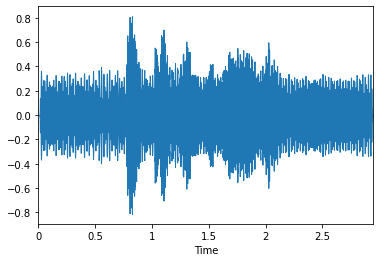

In [3]:
x, sr = librosa.load(os.path.join("rabia.wav"), res_type='kaiser_fast',duration=3)
librosa.display.waveplot(x,sr=sr)

## Gürültüden arındırılmış ses dosyamız

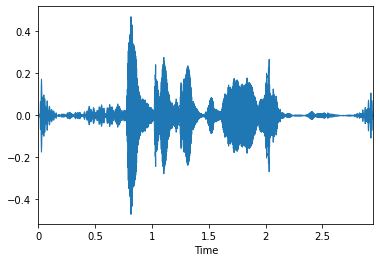

In [4]:
x, sr = librosa.load(os.path.join("rabia.wav"), res_type='kaiser_fast',duration=3)
reduced_noise = nr.reduce_noise(audio_clip=x, noise_clip=x)
librosa.display.waveplot(reduced_noise,sr=sr)
import sounddevice as sd
sd.play(reduced_noise, sr)

## Mel spektogramı ile ses dosyamızın görünümü

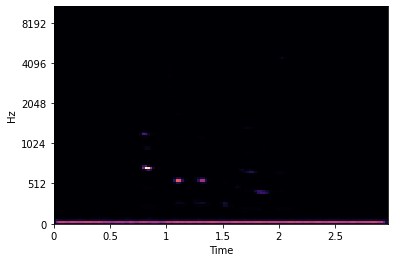

In [5]:
# Gösterdiğim spektogramlar onların altında bulunan fonksiyonda(extraxt_features) aldığımız
# özelliklere dair bilgilendirme amaçlıdır
x, sr = librosa.load(os.path.join("rabia.wav"), res_type='kaiser_fast',duration=3)
ps = librosa.feature.melspectrogram(x, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

## Chroma ile ses dosyamızın görünümü

C:\Users\Omer\Anaconda3\lib\site-packages\librosa\display.py:823: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


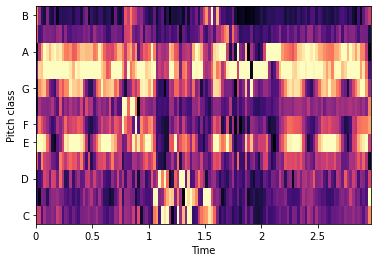

In [6]:
x, sr = librosa.load(os.path.join("rabia.wav"), res_type='kaiser_fast',duration=3)
stft=librosa.stft(x)
fig, ax = plt.subplots()
chroma=librosa.feature.chroma_stft(S=stft, sr=sr)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time',ax=ax)

## MFCC ile ses dosyamızın görünümü

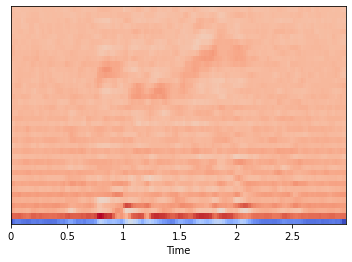

In [7]:
x, sr = librosa.load(os.path.join("rabia.wav"), res_type='kaiser_fast',duration=3)
fig, ax = plt.subplots()
mfccs=librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', ax=ax)

In [8]:
# Her dosyamızın ses yapısı açısında özelliklerini araştırıp
# "result" adlı arrayimize horizantal olarak stack mantığıyla ekliyoruz
def extract_features(file_name, mfcc, chroma, mel, noisy):
    #Librosa kütüphanesi iki öge geriye döndürür
    # 1.si ses zaman serimiz
    # 2.si ise sample rate adı verilen örneklem oranı
    # Load metodunda resource type ımızı yükleme zamanımızı biraz azaltmak için kaiser_fast seçtik
    x, sample_rate = librosa.load(os.path.join(file_name),duration=3)
    # Özelliklerimizi ekleyeceğimiz "result" adında boş bir numpy array oluşturduk
    result=np.array([])
    # Eğer gelen ses dosyamız gürültülü ise bu işleme sokmaktayız
    if noisy:
        x = nr.reduce_noise(audio_clip=x, noise_clip=x)
    # Aşağıdaki satırlarda özellik çıkarımı yaptıktan sonra bir değişkene atadık
    # Bu değişkeni de result dizimize yatay bir şekilde dahil ettik
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        stft=np.abs(librosa.stft(x))
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(x, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
        
    # Son olarak result dizimizi döndürdük
    return result

In [9]:
# Bu fonksiyonu veri setlerimizin test ve train diye ayrılması için oluşturdum
def load_data(test_size=0.2):
    # Yukarda belirtmiş olduğum parametre data setimizdeki test verilerinin oranıdır
    # Aşağıda ise x ve y adında boş iki adet dizi oluşturduk
    # x bizim ses özelliklerimizi
    # y ise labelları olan duyguları temsil edecek
    
    x,y=[],[]
    
    # Dosyaları seçmek için glob kütüphanesini kullanmak daha kullanışlı olduğundan onu seçtim
    # Bu kütüphane ile dosyaların isim veya türlerine göre seçim yapabilmekteyiz
    print("Ravdess Datas Loading ...")
    for file in tqdm(glob.glob('./Audio_Speech_Actors_01-24/Actor_*/*.wav')):
        
        # For döngüsünden gelen dosyamızın adını dosyamızın adından alacağımız değerlerden dolayı aldım
        # Dosyamızın ismindeki her bir numara bizim için anlam ifade etmekte
        # (Ayrıntı için https://zenodo.org/record/1188976#.X7KHVpNR3IU file identifiers kısmı)
        # Duygular kısmı dosya ismini - lere göre bir array haline getirirsek 2. indekste yer almakta
        file_name=os.path.basename(file)
        emotion=int(file_name.split("-")[2])-1
        
        if emotion not in observed_emotions:
            continue
            
        # Alttaki sorgu kısmında gözlemlediğimiz duygulardaki dosyaları seçmek için bir koşul koydum
        # Altta ise extract_feature fonksiyonumuzdan gelen değerleri feature değişkenine eşitleyip
        # X ve Y dizilerimize duygu ve özellikleri ekledik
        
        feature=extract_features(file, mfcc=True, chroma=False, mel=False, noisy=False)
        
        x.append(feature)
        y.append(emotion)
    
    # Bu kısımda ravdessin formatına çevirdiğim Savee verilerinin
    # X ve Y dizilerine dahil edilmesini gerçekleştirdim
    print("Augmented Datas Loading ...")
    for file in tqdm(glob.glob('./Augmented/*.wav')):
        
        file_name=os.path.basename(file)
        emotion=int(file_name.split("-")[2])-1
        
        if emotion not in observed_emotions:
            continue
        
        feature=extract_features(file, mfcc=True, chroma=False, mel=False, noisy=False)
        
        x.append(feature)
        y.append(emotion)
        
    # Son olarak ise sklearn kütüphanesindeki train_test_split metodunu train ve test verileri için kullandık
    # Random state verimizin her zaman aynı yerden bölünmesi için verdiğimiz bir sabit değer
    
    return train_test_split(np.array(x), np.array(y), test_size=test_size, train_size= 1-test_size,random_state=42,shuffle=1)

In [12]:
# Bu kısımda fonksiyonumuzdan gelen değerleri x in ve y nin train test dosyalarına aktardık

x_train,x_test,y_train,y_test=load_data(test_size=0.25)

Ravdess Datas Loading ...



Augmented Datas Loading ...


In [13]:
# Verilerimizin boyutlarını ve ölçeklenmesini bu şekilde görebiliyoruz
print((x_train.shape[0], x_test.shape[0] , len(y_train), len(y_test)))

(3807, 1269, 3807, 1269)


## Decision Tree
### -Parametresiz

In [14]:
# İlk Olarak öğrendiğim algoritmalardan olan Decision Tree 
# algoritmasını parametresiz olarak verisetime uyguladım

modelDT = DecisionTreeClassifier()
modelDT.fit(x_train, y_train)
print(f'Parametresiz modelimizin başarı oranı : {modelDT.score(x_test, y_test)}')
y_predict = modelDT.predict(x_test)

Parametresiz modelimizin başarı oranı : 0.5862884160756501


### -Parametreli

In [15]:
# Sonrasında classtaki tüm parametreleri kullanarak başarı oranlarında az da olabilse
# farklılıklar oluşturabileceğimi öğrendim
modelDT= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
modelDT.fit(x_train,y_train)
print(f'Parametreli modelimizin başarı oranı : {modelDT.score(x_test, y_test)}')
y_predict = modelDT.predict(x_test)
# Bu şekilde de hangi duygunun daha iyi öğrenilip hangisinin daha az
# öğrenildiğini görebilmekteyiz
print("\n"+classification_report(y_test,y_predict))

Parametreli modelimizin başarı oranı : 0.5894405043341213

              precision    recall  f1-score   support

           0       0.42      0.51      0.46       136
           1       0.60      0.61      0.61       303
           2       0.57      0.61      0.59       270
           3       0.54      0.49      0.52       273
           4       0.75      0.68      0.71       287

    accuracy                           0.59      1269
   macro avg       0.58      0.58      0.58      1269
weighted avg       0.60      0.59      0.59      1269



## KNN ve GridSearchCV

In [16]:
# Sonrasında KNN algoritmasını GridSearchCV ile taratarak
# algoritma için en iyi parametreleri araştırdık

from sklearn.model_selection import GridSearchCV

# Aranacak ve diğerleri ile kombinlenecek olan 
# Hiper parametreleri bir sözlük(dict) veri tipine aktardık 

grid_params = {
    'n_neighbors': [6, 8, 10, 12 , 14 , 16 , 18],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree','brute'],
    'leaf_size': [2,3,4,5,6],
    'metric': ['euclidean', 'manhattan','minkowski']
}

# KNN modelimizi GridSearchCV ile oluşturduk ve parametreleri ekledik
modelKNN = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1,verbose=2)
modelKNN.fit(x_train, y_train)
# Skorumuzu ve Confusion Matrisimizi görüntüledik
print(f'GridSearchCV den gelen en iyi başarı oranımız : {modelKNN.score(x_test, y_test)}')
y_predict = modelKNN.predict(x_test)
# Burada modelimizin hangi duyguyu , hangi duygular ile karıştırdığını görebiliriz
# (a,a) olan koordinatlarda doğru tahmin edilen duyguları görebilmekteyiz
print(f'Confusion Matrisimiz : \n{confusion_matrix(y_predict, y_test)}')

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:  6.6min finished


GridSearchCV den gelen en iyi başarı oranımız : 0.8534278959810875
Confusion Matrisimiz : 
[[111  15   4  15   0]
 [ 14 265  13  24   0]
 [  0  13 226  13  15]
 [ 11   9   8 211   2]
 [  0   1  19  10 270]]


In [17]:
y_predict = modelKNN.predict(x_test)

In [18]:
# GridSearchCV bizim için sözlüğümüzdeki
# en uygun KNN parametrelerini buldu
modelKNN.best_params_

{'algorithm': 'auto',
 'leaf_size': 2,
 'metric': 'manhattan',
 'n_neighbors': 6,
 'weights': 'distance'}

## KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

modelKNN = KNeighborsClassifier(algorithm= 'auto',
                                leaf_size= 2,
                                metric= 'manhattan',
                                n_neighbors= 6,
                                weights= 'distance')
modelKNN.fit(x_train, y_train)
y_predict = modelKNN.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_predict)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 85.34%


## MLP

In [20]:
# Multi-layer Perceptron(MLP) yani Çok Katmanlı Algılayıcılar ile denemeye başladık
# Hiper parametreleri GridSearch ile adım adım hesaplayarak bulduk

modelMLP=MLPClassifier(alpha=0.0001, epsilon=1e-08,batch_size=562 ,hidden_layer_sizes=(562,), solver="adam" , learning_rate='invscaling',activation="logistic", max_iter=5000)

In [21]:
#Modelimizi fit edip test datamız içerisinden tahmin yapmasını istedik
modelMLP.fit(x_train,y_train)
y_pred=modelMLP.predict(x_test)

In [22]:
# Burada hangi duyguların hangi başarı skorlarına sahip olduklarını
# Yani modelimizin hangi duygularda daha başarılı olduğunu anlıyoruz
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       136
           1       0.89      0.92      0.91       303
           2       0.89      0.84      0.87       270
           3       0.87      0.85      0.86       273
           4       0.89      0.92      0.90       287

    accuracy                           0.88      1269
   macro avg       0.88      0.88      0.88      1269
weighted avg       0.88      0.88      0.88      1269



In [23]:
# Ve başarı oranımız aşağıda gördüğümüz gibidir
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 88.18%


In [26]:
# Dışarıdan bir veri girerek deneme yaptık
from playsound import playsound
for file in glob.glob('rabia.wav'):
    test_file = file
    test_features = np.array(extract_features(test_file, mfcc=True, chroma=False, mel=False,noisy=True))
predY = modelKNN.predict_proba([test_features])
print(predY)

"""0:'Normal',
  1:'Sakin',
  2:'Mutlu',
  3:'Üzgün',
  4:'Sinirli'"""

[[0.         0.         0.68505957 0.         0.31494043]]


"0:'Normal',\n  1:'Sakin',\n  2:'Mutlu',\n  3:'Üzgün',\n  4:'Sinirli'"

In [25]:
# Confusion matrix ile de modelimizin hatalı tahminlerini görebilmekteyiz

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,y_pred)
print (matrix)

[[114   6   3   8   5]
 [  5 280   8   6   4]
 [  3  11 228   8  20]
 [ 11  16   8 233   5]
 [  1   2   8  12 264]]


## CNN

In [39]:
# Sonrasında nöral ağlar ile çalışmaya başladım
# Ve CNN(Convolutional Neural Network)'nin bu tarz veriler için
# İyi bir sınıflandırıcı olduğuna kanaat getirdim

# CNN sınıflandırıcımız verimizde genişlik istediğinden dolayı
# Verisetimize 1 genişlik verdik
x_traincnn = np.expand_dims(x_train , axis = 2)
x_testcnn = np.expand_dims(x_test , axis = 2)

In [40]:
# Yeni boyutlarımız aşağıdaki gibidir 
x_traincnn.shape , x_testcnn.shape

((3807, 40, 1), (1269, 40, 1))

In [41]:
# CNN için gerekli olan keras kütüphanesinden
# ihtiyacımız olanları projemize dahil ediyoruz
import keras
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,AveragePooling1D,Dense,BatchNormalization
from keras.layers import Flatten,Dropout,Activation
from keras.models import Model
from keras import optimizers

In [53]:
# CNN yapımızı oluşturmaya başladık
model = Sequential()
# Convolutional Katmanı ekledik
model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(BatchNormalization())
# Aktivizasyon fonksiyonu olarak reluyu seçtik
model.add(Activation('relu'))
# Dropout ile modelimizin öğrenme hızını yavaşlatarak
# daha iyi öğrenmesini amaçladık
model.add(Dropout(0.1))
# Max Pooling ile verisetimizdeki her n veriden en büyük
# veriyi alıp anlamlı verileri almayı amaçladık
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(256, 5,padding='same',))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(4)))

# CNN ile işimiz bittikten sonra Flatten ile tüm verilerimizi bir düzleme oturttuk
# Ve ardından Fully Connected Layer ile verilerimizi bağladık
# Son katmanda sonuçlara erişmek için 8 lik(Çünkü 8 duygumuz var) bir Dense Layer ı
# oluşturup ardından softmax aktivasyon fonksiyonu ile işlemimizi tamamladık
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.1))
model.add(Dense(5))
model.add(Activation('softmax'))

# Optimizerlardan RMSprop u kullanıp öğrenme katsayısını 0.00005 e indirdik
# Bu sayede modelimiz öğrenme işlemini daha yavaştan yapacaktır
opt = optimizers.RMSprop(lr=0.000015, rho=0.9, epsilon=None, decay=0.0)

# Modelimizi compile ettik 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Modelimizi yazdırdık
print(model.summary())

# Son olarak fit ederek öğrenme sürecini başlattık
# Batch size ile bir seferde alınacak veri sayısını
# Epochs ile de kaç sefer çalışacağını
# Validation data ile de hangi veri üzerinden doğrulama yapacağını modelimize söyledik
cnnhistory=model.fit(x_traincnn, y_train, batch_size=4,epochs=1000, validation_data=(x_testcnn, y_test),verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
batch_normalization_6 (Batch (None, 40, 128)           512       
_________________________________________________________________
activation_9 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 256)           164096    
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 256)          

Epoch 56/1000
952/952 - 8s - loss: 1.0437 - accuracy: 0.5829 - val_loss: 0.9318 - val_accuracy: 0.6060
Epoch 57/1000
952/952 - 7s - loss: 1.0601 - accuracy: 0.5760 - val_loss: 0.9607 - val_accuracy: 0.5894
Epoch 58/1000
952/952 - 8s - loss: 1.0549 - accuracy: 0.5745 - val_loss: 1.0046 - val_accuracy: 0.5697
Epoch 59/1000
952/952 - 7s - loss: 1.0334 - accuracy: 0.5900 - val_loss: 0.9535 - val_accuracy: 0.5871
Epoch 60/1000
952/952 - 7s - loss: 1.0220 - accuracy: 0.5789 - val_loss: 0.9951 - val_accuracy: 0.5705
Epoch 61/1000
952/952 - 6s - loss: 1.0153 - accuracy: 0.5965 - val_loss: 1.0015 - val_accuracy: 0.5705
Epoch 62/1000
952/952 - 6s - loss: 1.0300 - accuracy: 0.5913 - val_loss: 0.9245 - val_accuracy: 0.6052
Epoch 63/1000
952/952 - 6s - loss: 1.0258 - accuracy: 0.5931 - val_loss: 0.9765 - val_accuracy: 0.5910
Epoch 64/1000
952/952 - 7s - loss: 1.0247 - accuracy: 0.5902 - val_loss: 0.9564 - val_accuracy: 0.5957
Epoch 65/1000
952/952 - 7s - loss: 1.0092 - accuracy: 0.5994 - val_loss: 

Epoch 136/1000
952/952 - 6s - loss: 0.7917 - accuracy: 0.7032 - val_loss: 0.8316 - val_accuracy: 0.6619
Epoch 137/1000
952/952 - 6s - loss: 0.7844 - accuracy: 0.6845 - val_loss: 0.7810 - val_accuracy: 0.6848
Epoch 138/1000
952/952 - 6s - loss: 0.7905 - accuracy: 0.6879 - val_loss: 0.7625 - val_accuracy: 0.6919
Epoch 139/1000
952/952 - 6s - loss: 0.7661 - accuracy: 0.6985 - val_loss: 0.8400 - val_accuracy: 0.6612
Epoch 140/1000
952/952 - 6s - loss: 0.7685 - accuracy: 0.7008 - val_loss: 0.8504 - val_accuracy: 0.6572
Epoch 141/1000
952/952 - 6s - loss: 0.7776 - accuracy: 0.6950 - val_loss: 0.7697 - val_accuracy: 0.6950
Epoch 142/1000
952/952 - 6s - loss: 0.7775 - accuracy: 0.6958 - val_loss: 0.8230 - val_accuracy: 0.6690
Epoch 143/1000
952/952 - 6s - loss: 0.7665 - accuracy: 0.7090 - val_loss: 0.8133 - val_accuracy: 0.6714
Epoch 144/1000
952/952 - 6s - loss: 0.7962 - accuracy: 0.6835 - val_loss: 0.8329 - val_accuracy: 0.6588
Epoch 145/1000
952/952 - 6s - loss: 0.7802 - accuracy: 0.6966 - 

Epoch 215/1000
952/952 - 7s - loss: 0.6499 - accuracy: 0.7518 - val_loss: 0.7153 - val_accuracy: 0.7218
Epoch 216/1000
952/952 - 6s - loss: 0.6844 - accuracy: 0.7394 - val_loss: 0.8368 - val_accuracy: 0.6824
Epoch 217/1000
952/952 - 6s - loss: 0.6747 - accuracy: 0.7444 - val_loss: 0.7246 - val_accuracy: 0.7195
Epoch 218/1000
952/952 - 7s - loss: 0.6592 - accuracy: 0.7515 - val_loss: 0.7312 - val_accuracy: 0.7124
Epoch 219/1000
952/952 - 7s - loss: 0.6606 - accuracy: 0.7431 - val_loss: 0.7433 - val_accuracy: 0.7179
Epoch 220/1000
952/952 - 7s - loss: 0.6781 - accuracy: 0.7355 - val_loss: 0.6924 - val_accuracy: 0.7289
Epoch 221/1000
952/952 - 7s - loss: 0.6604 - accuracy: 0.7415 - val_loss: 0.6993 - val_accuracy: 0.7344
Epoch 222/1000
952/952 - 6s - loss: 0.6484 - accuracy: 0.7499 - val_loss: 0.6737 - val_accuracy: 0.7344
Epoch 223/1000
952/952 - 6s - loss: 0.6674 - accuracy: 0.7444 - val_loss: 0.7584 - val_accuracy: 0.7029
Epoch 224/1000
952/952 - 6s - loss: 0.6690 - accuracy: 0.7510 - 

Epoch 294/1000
952/952 - 6s - loss: 0.5697 - accuracy: 0.7804 - val_loss: 0.6726 - val_accuracy: 0.7470
Epoch 295/1000
952/952 - 6s - loss: 0.6153 - accuracy: 0.7625 - val_loss: 0.6748 - val_accuracy: 0.7407
Epoch 296/1000
952/952 - 6s - loss: 0.5925 - accuracy: 0.7770 - val_loss: 0.6925 - val_accuracy: 0.7384
Epoch 297/1000
952/952 - 6s - loss: 0.6001 - accuracy: 0.7759 - val_loss: 0.7087 - val_accuracy: 0.7392
Epoch 298/1000
952/952 - 6s - loss: 0.6068 - accuracy: 0.7667 - val_loss: 0.6382 - val_accuracy: 0.7612
Epoch 299/1000
952/952 - 6s - loss: 0.6080 - accuracy: 0.7639 - val_loss: 0.6350 - val_accuracy: 0.7612
Epoch 300/1000
952/952 - 6s - loss: 0.6058 - accuracy: 0.7670 - val_loss: 0.7430 - val_accuracy: 0.7305
Epoch 301/1000
952/952 - 6s - loss: 0.5900 - accuracy: 0.7730 - val_loss: 0.6711 - val_accuracy: 0.7470
Epoch 302/1000
952/952 - 6s - loss: 0.5968 - accuracy: 0.7717 - val_loss: 0.7424 - val_accuracy: 0.7352
Epoch 303/1000
952/952 - 6s - loss: 0.5862 - accuracy: 0.7765 - 

Epoch 373/1000
952/952 - 7s - loss: 0.5449 - accuracy: 0.7906 - val_loss: 0.6650 - val_accuracy: 0.7636
Epoch 374/1000
952/952 - 7s - loss: 0.5487 - accuracy: 0.7906 - val_loss: 0.6921 - val_accuracy: 0.7565
Epoch 375/1000
952/952 - 7s - loss: 0.5573 - accuracy: 0.7857 - val_loss: 0.6685 - val_accuracy: 0.7612
Epoch 376/1000
952/952 - 6s - loss: 0.5321 - accuracy: 0.8014 - val_loss: 0.7322 - val_accuracy: 0.7486
Epoch 377/1000
952/952 - 6s - loss: 0.5470 - accuracy: 0.7938 - val_loss: 0.6960 - val_accuracy: 0.7518
Epoch 378/1000
952/952 - 6s - loss: 0.5510 - accuracy: 0.7959 - val_loss: 0.7245 - val_accuracy: 0.7439
Epoch 379/1000
952/952 - 6s - loss: 0.5664 - accuracy: 0.7930 - val_loss: 0.6842 - val_accuracy: 0.7573
Epoch 380/1000
952/952 - 6s - loss: 0.5440 - accuracy: 0.7964 - val_loss: 0.6804 - val_accuracy: 0.7557
Epoch 381/1000
952/952 - 6s - loss: 0.5407 - accuracy: 0.7922 - val_loss: 0.6714 - val_accuracy: 0.7628
Epoch 382/1000
952/952 - 6s - loss: 0.5274 - accuracy: 0.7970 - 

Epoch 452/1000
952/952 - 7s - loss: 0.5000 - accuracy: 0.8054 - val_loss: 0.6785 - val_accuracy: 0.7754
Epoch 453/1000
952/952 - 6s - loss: 0.5152 - accuracy: 0.8111 - val_loss: 0.7060 - val_accuracy: 0.7660
Epoch 454/1000
952/952 - 6s - loss: 0.5182 - accuracy: 0.8080 - val_loss: 0.6796 - val_accuracy: 0.7730
Epoch 455/1000
952/952 - 7s - loss: 0.5029 - accuracy: 0.8103 - val_loss: 0.6781 - val_accuracy: 0.7770
Epoch 456/1000
952/952 - 6s - loss: 0.5124 - accuracy: 0.8169 - val_loss: 0.6554 - val_accuracy: 0.7809
Epoch 457/1000
952/952 - 6s - loss: 0.4992 - accuracy: 0.8172 - val_loss: 0.6869 - val_accuracy: 0.7612
Epoch 458/1000
952/952 - 6s - loss: 0.4978 - accuracy: 0.8106 - val_loss: 0.6819 - val_accuracy: 0.7691
Epoch 459/1000
952/952 - 6s - loss: 0.5141 - accuracy: 0.8061 - val_loss: 0.6181 - val_accuracy: 0.7872
Epoch 460/1000
952/952 - 6s - loss: 0.4834 - accuracy: 0.8243 - val_loss: 0.6096 - val_accuracy: 0.7920
Epoch 461/1000
952/952 - 6s - loss: 0.4754 - accuracy: 0.8222 - 

Epoch 531/1000
952/952 - 6s - loss: 0.4830 - accuracy: 0.8177 - val_loss: 0.6541 - val_accuracy: 0.7833
Epoch 532/1000
952/952 - 6s - loss: 0.4713 - accuracy: 0.8167 - val_loss: 0.6928 - val_accuracy: 0.7707
Epoch 533/1000
952/952 - 6s - loss: 0.4696 - accuracy: 0.8272 - val_loss: 0.7274 - val_accuracy: 0.7738
Epoch 534/1000
952/952 - 6s - loss: 0.4898 - accuracy: 0.8240 - val_loss: 0.6461 - val_accuracy: 0.7864
Epoch 535/1000
952/952 - 6s - loss: 0.4773 - accuracy: 0.8300 - val_loss: 0.7021 - val_accuracy: 0.7691
Epoch 536/1000
952/952 - 6s - loss: 0.4810 - accuracy: 0.8258 - val_loss: 0.7036 - val_accuracy: 0.7801
Epoch 537/1000
952/952 - 6s - loss: 0.4591 - accuracy: 0.8298 - val_loss: 0.7000 - val_accuracy: 0.7794
Epoch 538/1000
952/952 - 6s - loss: 0.4762 - accuracy: 0.8180 - val_loss: 0.6495 - val_accuracy: 0.7935
Epoch 539/1000
952/952 - 6s - loss: 0.4795 - accuracy: 0.8151 - val_loss: 0.7070 - val_accuracy: 0.7738
Epoch 540/1000
952/952 - 6s - loss: 0.4736 - accuracy: 0.8279 - 

Epoch 610/1000
952/952 - 8s - loss: 0.4522 - accuracy: 0.8319 - val_loss: 0.7270 - val_accuracy: 0.7801
Epoch 611/1000
952/952 - 8s - loss: 0.4461 - accuracy: 0.8427 - val_loss: 0.7158 - val_accuracy: 0.7872
Epoch 612/1000
952/952 - 7s - loss: 0.4375 - accuracy: 0.8337 - val_loss: 0.6739 - val_accuracy: 0.7951
Epoch 613/1000
952/952 - 7s - loss: 0.4558 - accuracy: 0.8324 - val_loss: 0.6860 - val_accuracy: 0.7841
Epoch 614/1000
952/952 - 7s - loss: 0.4339 - accuracy: 0.8400 - val_loss: 0.6707 - val_accuracy: 0.7951
Epoch 615/1000
952/952 - 8s - loss: 0.4379 - accuracy: 0.8327 - val_loss: 0.6670 - val_accuracy: 0.7904
Epoch 616/1000
952/952 - 7s - loss: 0.4492 - accuracy: 0.8327 - val_loss: 0.7625 - val_accuracy: 0.7754
Epoch 617/1000
952/952 - 8s - loss: 0.4460 - accuracy: 0.8345 - val_loss: 0.7029 - val_accuracy: 0.7833
Epoch 618/1000
952/952 - 8s - loss: 0.4262 - accuracy: 0.8337 - val_loss: 0.7251 - val_accuracy: 0.7849
Epoch 619/1000
952/952 - 8s - loss: 0.4485 - accuracy: 0.8366 - 

Epoch 689/1000
952/952 - 9s - loss: 0.4160 - accuracy: 0.8524 - val_loss: 0.7217 - val_accuracy: 0.7959
Epoch 690/1000
952/952 - 10s - loss: 0.4438 - accuracy: 0.8424 - val_loss: 0.7244 - val_accuracy: 0.7959
Epoch 691/1000
952/952 - 11s - loss: 0.4073 - accuracy: 0.8421 - val_loss: 0.6734 - val_accuracy: 0.8038
Epoch 692/1000
952/952 - 10s - loss: 0.4330 - accuracy: 0.8387 - val_loss: 0.7741 - val_accuracy: 0.7801
Epoch 693/1000
952/952 - 10s - loss: 0.4529 - accuracy: 0.8377 - val_loss: 0.7590 - val_accuracy: 0.7801
Epoch 694/1000
952/952 - 10s - loss: 0.4491 - accuracy: 0.8385 - val_loss: 0.7317 - val_accuracy: 0.7935
Epoch 695/1000
952/952 - 11s - loss: 0.4257 - accuracy: 0.8377 - val_loss: 0.7494 - val_accuracy: 0.7904
Epoch 696/1000
952/952 - 10s - loss: 0.4382 - accuracy: 0.8474 - val_loss: 0.7167 - val_accuracy: 0.7959
Epoch 697/1000
952/952 - 9s - loss: 0.4067 - accuracy: 0.8450 - val_loss: 0.7583 - val_accuracy: 0.7864
Epoch 698/1000
952/952 - 10s - loss: 0.4370 - accuracy: 0

Epoch 768/1000
952/952 - 8s - loss: 0.4109 - accuracy: 0.8574 - val_loss: 0.7875 - val_accuracy: 0.7880
Epoch 769/1000
952/952 - 8s - loss: 0.4052 - accuracy: 0.8484 - val_loss: 0.7149 - val_accuracy: 0.7991
Epoch 770/1000
952/952 - 8s - loss: 0.3961 - accuracy: 0.8516 - val_loss: 0.6613 - val_accuracy: 0.8156
Epoch 771/1000
952/952 - 8s - loss: 0.3980 - accuracy: 0.8574 - val_loss: 0.7233 - val_accuracy: 0.8030
Epoch 772/1000
952/952 - 8s - loss: 0.4105 - accuracy: 0.8505 - val_loss: 0.7564 - val_accuracy: 0.7959
Epoch 773/1000
952/952 - 8s - loss: 0.4088 - accuracy: 0.8524 - val_loss: 0.7233 - val_accuracy: 0.8030
Epoch 774/1000
952/952 - 8s - loss: 0.3961 - accuracy: 0.8526 - val_loss: 0.7322 - val_accuracy: 0.8030
Epoch 775/1000
952/952 - 8s - loss: 0.4141 - accuracy: 0.8519 - val_loss: 0.7944 - val_accuracy: 0.7841
Epoch 776/1000
952/952 - 8s - loss: 0.4251 - accuracy: 0.8471 - val_loss: 0.7476 - val_accuracy: 0.7967
Epoch 777/1000
952/952 - 8s - loss: 0.4034 - accuracy: 0.8508 - 

Epoch 847/1000
952/952 - 8s - loss: 0.3945 - accuracy: 0.8582 - val_loss: 0.6796 - val_accuracy: 0.8054
Epoch 848/1000
952/952 - 8s - loss: 0.3650 - accuracy: 0.8671 - val_loss: 0.7589 - val_accuracy: 0.8006
Epoch 849/1000
952/952 - 7s - loss: 0.3985 - accuracy: 0.8613 - val_loss: 0.6950 - val_accuracy: 0.8038
Epoch 850/1000
952/952 - 7s - loss: 0.3783 - accuracy: 0.8650 - val_loss: 0.7902 - val_accuracy: 0.7959
Epoch 851/1000
952/952 - 7s - loss: 0.3829 - accuracy: 0.8692 - val_loss: 0.7222 - val_accuracy: 0.8101
Epoch 852/1000
952/952 - 8s - loss: 0.3692 - accuracy: 0.8663 - val_loss: 0.7083 - val_accuracy: 0.8109
Epoch 853/1000
952/952 - 8s - loss: 0.3871 - accuracy: 0.8642 - val_loss: 0.7874 - val_accuracy: 0.7998
Epoch 854/1000
952/952 - 8s - loss: 0.3761 - accuracy: 0.8595 - val_loss: 0.7721 - val_accuracy: 0.8077
Epoch 855/1000
952/952 - 7s - loss: 0.3840 - accuracy: 0.8595 - val_loss: 0.8301 - val_accuracy: 0.8006
Epoch 856/1000
952/952 - 7s - loss: 0.3742 - accuracy: 0.8618 - 

Epoch 926/1000
952/952 - 8s - loss: 0.3812 - accuracy: 0.8692 - val_loss: 0.7653 - val_accuracy: 0.8077
Epoch 927/1000
952/952 - 8s - loss: 0.3618 - accuracy: 0.8755 - val_loss: 0.7578 - val_accuracy: 0.7967
Epoch 928/1000
952/952 - 7s - loss: 0.3557 - accuracy: 0.8702 - val_loss: 0.7671 - val_accuracy: 0.8077
Epoch 929/1000
952/952 - 7s - loss: 0.3737 - accuracy: 0.8716 - val_loss: 0.7613 - val_accuracy: 0.8125
Epoch 930/1000
952/952 - 8s - loss: 0.3659 - accuracy: 0.8658 - val_loss: 0.7860 - val_accuracy: 0.8014
Epoch 931/1000
952/952 - 8s - loss: 0.3762 - accuracy: 0.8660 - val_loss: 0.7799 - val_accuracy: 0.8101
Epoch 932/1000
952/952 - 8s - loss: 0.3890 - accuracy: 0.8600 - val_loss: 0.7117 - val_accuracy: 0.8140
Epoch 933/1000
952/952 - 8s - loss: 0.3701 - accuracy: 0.8663 - val_loss: 0.7327 - val_accuracy: 0.8061
Epoch 934/1000
952/952 - 8s - loss: 0.3713 - accuracy: 0.8673 - val_loss: 0.7723 - val_accuracy: 0.8022
Epoch 935/1000
952/952 - 8s - loss: 0.3914 - accuracy: 0.8587 - 

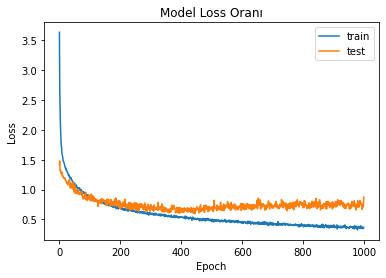

In [54]:
# Loss oranımızın grafiği
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Model Loss Oranı')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss.png')

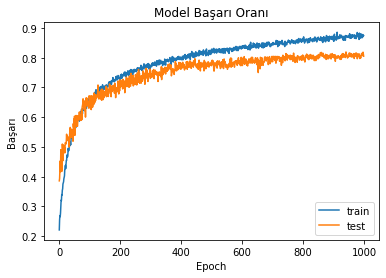

In [55]:
# Başarı oranımızın grafiği
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('Model Başarı Oranı')
plt.ylabel('Başarı')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('accuracy.png')

In [29]:
# Modelimizi kaydediyoruz
filename = 'Models/modelMLP.sav'
pickle.dump(modelMLP, open(filename, 'wb'))

In [33]:
# Tekrar yüklemek istersek de bu şekilde yeniden yükleme işlemini
# gerçekleştiriyoruz
loaded_model = pickle.load(open(filename, 'rb'))

0.8739164696611506
